# RNN with GRU Cell for Text Classification


In this notebook, we will explore how to build and train a Recurrent Neural Network (RNN) using a **GRU (Gated Recurrent Unit) Cell** for text classification. The GRU is a type of RNN designed to capture long-range dependencies in sequential data, such as text, by utilizing gating mechanisms that control the flow of information.


Text classification tasks, such as sentiment analysis or topic categorization, rely on understanding word order and context. **GRU cells** process text sequentially, retaining past information through **gating mechanisms**, making them effective for capturing dependencies in text.  


### **Objective:**  
- **Build** a GRU Cell model for text classification.  
- **Train** and **evaluate** the model on a labeled dataset.  
- **Tune** hyperparameters to optimize model performance.  
- **Save** the trained model for future use. 

Since the **text data preprocessing** (tokenization, padding, and encoding) has already been completed in the previous notebook, we will import the preprocessed data and proceed directly to the model construction, training, evaluation, and saving.



### **Steps:**  
1. **Import Required Libraries and Setup**: Load the necessary libraries and set up project paths and configurations.  
2. **Import Preprocessed Data**: Load the tokenized and padded text data from the previous notebook.  
3. **Model Construction**: Define an initial **GRU Cell architecture** as a baseline model.  
4. **Training the Model**: Train the model using the prepared dataset.  
5. **Evaluation**: Perform a **customized performance analysis** to assess the model's effectiveness on test data.  
6. **Hyperparameter Tuning**: Given computational constraints, we focus on optimizing only the most relevant parameters.  
7. **Save Models**: Save both the **initial trained GRU-based RNN model"** and the **best optimized model** for future use.


## 1. Import Required Libraries 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
import os
from datetime import datetime
from pathlib import Path
import pickle

import pandas as pd
import numpy as np

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import Sequential, backend as K
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Machine Learning & Model Evaluation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from scikeras.wrappers import KerasClassifier


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

import importlib
import itertools


### Setting Up Project Paths and Configurations

In [2]:
# Get the current notebook directory
CURRENT_DIR = Path(os.getcwd()).resolve()

# Automatically find the project root (go up 2 level)
PROJECT_ROOT = CURRENT_DIR.parents[2]

# Add project root to sys.path
sys.path.append(str(PROJECT_ROOT))

# Function to get relative paths from project root
def get_relative_path(absolute_path):
    return str(Path(absolute_path).relative_to(PROJECT_ROOT))

# Print project root directory
print(f"Project Root Directory: {PROJECT_ROOT.name}")  # Display only the root folder name

import config  # Now Python can find config.py
importlib.reload(config)  # Reload config to ensure any updates are applied


Project Root Directory: Data_Scientist_Rakuten_Project-main


<module 'config' from 'D:\\Data_Science\\Append_Data_Engineer_AWS_MLOPS\\Data_Scientist_Rakuten_Project-main\\config.py'>

## 2. Import Preprocessed Data

In this step, we will import the preprocessed data that has already been tokenized and padded, with the original training dataset split into training and testing sets using `train_test_split`. The data we are importing includes:


- **X_train_split_tokenized**: The training data that has been tokenized, padded, and split from the original dataset.
- **X_test_split_tokenized**: The testing data that has been tokenized, padded, and split from the original dataset.
- **y_train_split**: The corresponding target labels for the training data, also split after applying `train_test_split`.
- **y_test_split**: The corresponding target labels for the testing data, after splitting.


In [3]:
# Define paths for datasets
xtrain_tokenized_path = Path(config.X_TRAIN_SPLIT_TOKENIZED_PATH)
xtest_tokenized_path = Path(config.X_TEST_SPLIT_TOKENIZED_PATH)
y_train_split_path = Path(config.Y_TRAIN_SPLIT_PATH)
y_test_split_path = Path(config.Y_TEST_SPLIT_PATH)


#  Load tokenizer
tokenizer_path = Path(config.TOKENIZER_PATH)
                    
# Function to get relative paths from project root
def get_relative_path(absolute_path: Path):
    """Returns the relative path from the project root."""
    return str(absolute_path.relative_to(config.BASE_DIR))

# Function to load a Pickle file safely
def load_pickle(file_path: Path, dataset_name: str):
    """Loads a pickle file with error handling and basic visualization."""
    if not file_path.exists():
        print(f"Error: `{dataset_name}` file not found at {file_path}")
        return None

    try:
        data = pd.read_pickle(file_path)
        print(f"Successfully loaded `{dataset_name}` | Shape: {data.shape}")
        
#         # Display first rows if dataset is not empty
#         if not data.empty:
#             display(data.head())

        return data
    except Exception as e:
        print(f"Error loading `{dataset_name}`: {e}")
        return None

        return None, None

def load_tokenizer(tokenizer_path: Path):
    """Loads the saved tokenizer and determines the correct vocabulary size."""
    if not tokenizer_path.exists():
        print(f"Error: `Tokenizer` not found at {tokenizer_path}")
        return None, None

    try:
        with open(tokenizer_path, 'rb') as handle:
            tokenizer = pickle.load(handle)

        # Check if num_words was set during training
        if tokenizer.num_words is not None:
            vocab_size = tokenizer.num_words  # Use the predefined vocabulary limit
        else:
            vocab_size = len(tokenizer.word_index) + 1  # Otherwise, use the full vocabulary

        # Print vocabulary details separately
        print(f"Tokenizer successfully loaded.")
        print(f"Vocabulary size used (vocab_size): {vocab_size}")
        print(f"Total words found in dataset: {len(tokenizer.word_index)}")

        return tokenizer, vocab_size
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return None, None


    
# List of required files with their names
required_files = {
    "Tokenized Training Dataset": xtrain_tokenized_path,
    "Tokenized Testing Dataset": xtest_tokenized_path,
    "Training Labels": y_train_split_path,
    "Testing Labels": y_test_split_path,
    "Tokenizer": tokenizer_path  
}

# Check if files exist before loading
for name, path in required_files.items():
    if not path.exists():
        raise FileNotFoundError(f"Error: `{name}` file not found at {get_relative_path(path)}")

# Load datasets
X_train = load_pickle(xtrain_tokenized_path, "X_train_TokenizationSequencing.pkl")
X_test = load_pickle(xtest_tokenized_path, "X_test_TokenizationSequencing.pkl") # Submission dataset
y_train = load_pickle(y_train_split_path, "y_train_split.pkl")
y_test = load_pickle(y_test_split_path, "y_test_split.pkl")

# Load tokenizer
tokenizer, vocab_size = load_tokenizer(tokenizer_path)


Successfully loaded `X_train_TokenizationSequencing.pkl` | Shape: (67932, 500)
Successfully loaded `X_test_TokenizationSequencing.pkl` | Shape: (16984, 500)
Successfully loaded `y_train_split.pkl` | Shape: (67932,)
Successfully loaded `y_test_split.pkl` | Shape: (16984,)
Tokenizer successfully loaded.
Vocabulary size used (vocab_size): 20000
Total words found in dataset: 124636


## 3. RNN with GRUCell Model Construction

In this step, we construct an RNN model using a **GRU (Gated Recurrent Unit)** layer for text classification. The architecture includes:
- **Embedding Layer**: Converts words into dense vectors.
- **GRU Layer**: Processes sequential data.
- **Dropout Layers**: Reduces overfitting.
- **Global Average Pooling**: Reduces dimensionality.
- **Dense Layers**: Final classification with softmax.

In [4]:
# Define embedding dimension
embedding_dim = 100
# # Compute the maximum sequence length in X_train
# maxlen = max(len(seq) for seq in X_train)
# print(f"Dynamic maxlen set to: {maxlen}")

# Initialize the model
model = Sequential()
# Embedding layer
model.add(Embedding(vocab_size, embedding_dim))
# GRU layer with 128 units
model.add(RNN(GRUCell(128), return_sequences=True))
# Dropout layer to prevent overfitting
model.add(Dropout(0.3))
# Global average pooling layer
model.add(GlobalAveragePooling1D())
# Dense layer with ReLU activation
model.add(Dense(256, activation='relu'))
# Dropout layer
model.add(Dropout(0.3))
# Output layer with softmax activation for classification
model.add(Dense(27, activation='softmax'))

# Display model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 rnn (RNN)                   (None, None, 128)         88320     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

## 4. Model Compilation, Training, and Evaluation

Before fine-tuning, we start with a **initial version** of our **GRU-based RNN model** for multi-class text classification. This helps establish a **baseline** while **keeping training time and computational cost manageable**.  

#### **Model Parameters and Rationale**  

**Number of Epochs**: `EPOCHS = 5`  
Training for **5 epochs** is a good starting point because **text classification tasks** often require multiple epochs to capture meaningful patterns. We can increase the number of epochs later if needed.  

**Batch Size**: `BATCH_SIZE = 200`  
- A batch size of `200` balances **memory usage and convergence speed**.  
- Since **text sequences** can be long, using a **moderate batch size** prevents excessive **GPU/CPU memory consumption**.  
**Loss Function**: `sparse_categorical_crossentropy`  
- Best suited for **multi-class classification** with integer-labeled categories.  

**Optimizer**: `Adam (learning_rate=0.001)`  
- **Adam** (Adaptive Moment Estimation) is used because **it adjusts the learning rate automatically and helps the model learn faster and more efficiently**.
- We set `learning_rate=0.001`, which is the **default value**, but this can be fine-tuned later.  

**Metrics**: `accuracy` (excluding `weighted_f1` from `metrics`)  
- `accuracy` is a **quick and interpretable metric** for an initial evaluation.  
- If the **custom `weighted_f1` function does not work correctly**, we will compute the **Weighted F1-score manually** after evaluation to ensure accurate results.  



### 4.1 Custom Function for Weighted F1-Score

In [ ]:
# Custom function to calculate weighted F1 score==> TO BE TEST
def weighted_f1(y_true, y_pred):
    """
    Computes the weighted F1-score for multi-class classification.

    TensorFlow tensors are converted to NumPy arrays since sklearn's f1_score 
    requires NumPy input. However, TensorFlow functions do not support native NumPy 
    operations, so we use `tf.py_function` to wrap it.

    Args:
        y_true (tf.Tensor): True labels.
        y_pred (tf.Tensor): Predicted labels.

    Returns:
        tf.Tensor: Weighted F1-score computed using sklearn.
    """
    
    # Convert one-hot encoded predictions to class indices
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    def compute_f1(y_true_np, y_pred_np):
        """Helper function to compute F1-score in NumPy space."""
        return f1_score(y_true_np, y_pred_np, average='weighted')

    # Use tf.py_function to make the sklearn function compatible with TensorFlow
    return tf.py_function(func=compute_f1, inp=[y_true, y_pred], Tout=tf.float32)


### 4.2 Model Compilation and Training

In [5]:
%%time


# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=3,            # Stop training if no improvement after 3 epochs
    restore_best_weights=True  # Restore model weights from the best epoch
)



# Compile the model 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Set learning rate explicitly
    loss='sparse_categorical_crossentropy',  # For integer-labeled data
     metrics=['accuracy'] ## Only accuracy is included; weighted F1 will be computed manually
#    metrics=['accuracy', weighted_f1]  # Include both accuracy and weighted F1-score : ISSUE HERE
)

# Define training parameters as variables
BATCH_SIZE = 200
EPOCHS = 50

# Train the model using the defined variables
history = model.fit(          
    X_train, 
    y_train.values, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(X_test, y_test.values),
     callbacks=[early_stopping] 
)


Epoch 1/50
340/340 [==============================] - 477s 1s/step - loss: 2.7401 - accuracy: 0.2002 - val_loss: 1.8996 - val_accuracy: 0.4226
Epoch 2/50
340/340 [==============================] - 470s 1s/step - loss: 1.4703 - accuracy: 0.5332 - val_loss: 1.1547 - val_accuracy: 0.6547
Epoch 3/50
340/340 [==============================] - 482s 1s/step - loss: 0.9517 - accuracy: 0.7104 - val_loss: 0.9088 - val_accuracy: 0.7367
Epoch 4/50
340/340 [==============================] - 480s 1s/step - loss: 0.6867 - accuracy: 0.7978 - val_loss: 0.8443 - val_accuracy: 0.7582
Epoch 5/50
340/340 [==============================] - 477s 1s/step - loss: 0.5428 - accuracy: 0.8397 - val_loss: 0.8369 - val_accuracy: 0.7658
Epoch 6/50
340/340 [==============================] - 479s 1s/step - loss: 0.4472 - accuracy: 0.8671 - val_loss: 0.8655 - val_accuracy: 0.7704
Epoch 7/50
340/340 [==============================] - 482s 1s/step - loss: 0.3766 - accuracy: 0.8888 - val_loss: 0.9118 - val_accuracy: 0.7709

### 4.3 Saving the Trained Model

In [6]:
importlib.reload(config)  # Reload config to ensure any updates are applied
from datetime import datetime  # Import datetime for timestamp

# Define model name prefix (Change this for different architectures)
MODEL_NAME = "gru_model"  # Example: "gru_model", "lstm_model", etc.

# Ensure the directory exists before saving the model
os.makedirs(config.NEURAL_MODELS_DIR, exist_ok=True)

# Get current date and time in YYYYMMDD-HHMM format
timestamp = datetime.now().strftime("%Y%m%d-%H%M")

# Retrieve the number of epochs completed
if 'history' in globals():
    num_epochs = len(history.epoch)  # Actual trained epochs
else:
    num_epochs = "unknown"

# Define a compact filename with model name, epochs, and timestamp
model_filename = f"{MODEL_NAME}_E{EPOCHS}-T{num_epochs}_{timestamp}.h5"

# Full path for saving the model
model_path = os.path.join(config.NEURAL_MODELS_DIR, model_filename)

# Print the path where the model will be saved
print(f"Saving the model to: {model_path}")

try:
    # Save the trained Keras model (in .h5 format)
    model.save(model_path)

    print(f"Model saved successfully as {model_filename}")

except Exception as e:
    # Print error message if saving fails
    print(f"Error occurred while saving the model: {e}")


Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\neural\gru_model_E50-T8_20250225-0907.h5
Model saved successfully as gru_model_E50-T8_20250225-0907.h5


### 4.4 Load the saved Trained Model (Optional)

In [8]:
importlib.reload(config)  #Reload config to apply any updates

# Ask the user for the model name to load
model_name = "gru_model_E50-T8_20250225-0907.h5"  # Change this to the desired model filename

# Define the full path to the model
model_path = os.path.join(config.NEURAL_MODELS_DIR, model_name)

# Check if the model file exists
if os.path.exists(model_path):
    # Load the trained Keras model
    model = tf.keras.models.load_model(model_path)
    print(f"✔ Model loaded successfully from: {model_path}")
else:
    print(f"[X] Model file not found at: {model_path}")

✔ Model loaded successfully from: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\neural\gru_model_E50-T8_20250225-0907.h5


### 4.5 Model Evaluation on the Test Set

531/531 [==============================] - 79s 148ms/step - loss: 0.8369 - accuracy: 0.7658
[✔] Test Loss: 0.8369
[✔] Test Accuracy: 0.7658
531/531 [==============================] - 80s 151ms/step
[✔] Test Weighted F1-Score (computed manually): 0.7675

[✔] Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.50      0.41       643
           1       0.63      0.68      0.65       911
           2       0.79      0.68      0.73       319
           3       0.72      0.63      0.67      1002
           4       0.81      0.55      0.65       557
           5       0.92      0.89      0.90      1011
           6       0.73      0.62      0.67       533
           7       0.80      0.81      0.81       993
           8       0.52      0.48      0.50       408
           9       0.88      0.90      0.89       832
          10       0.72      0.72      0.72       961
          11       0.63      0.74      0.68       545
          12    

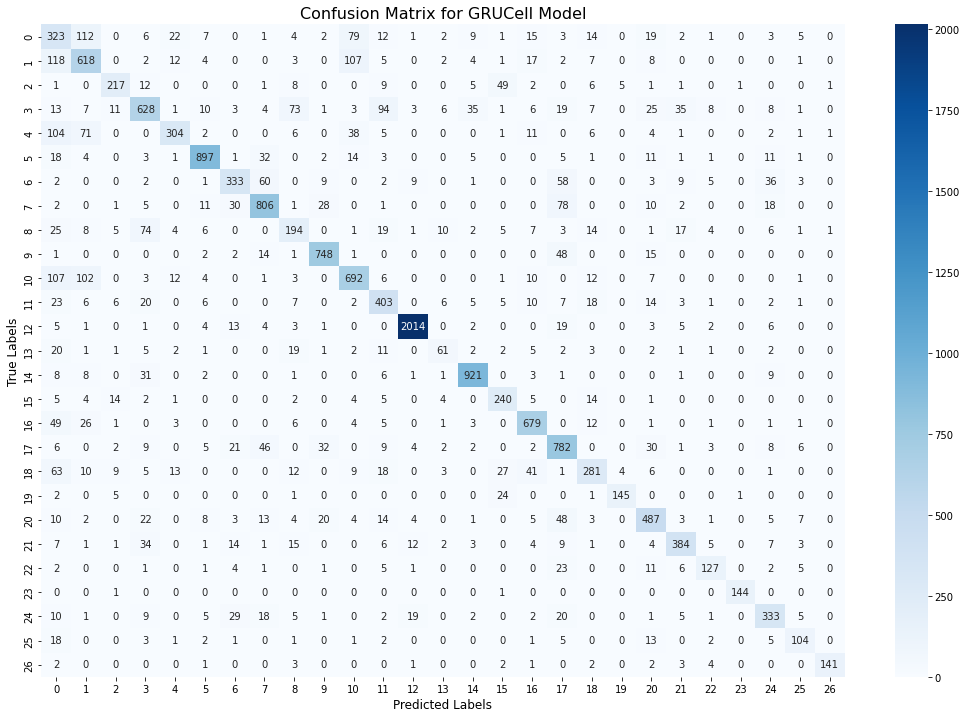

Wall time: 2min 40s


In [20]:
%%time

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test.values)

# Print evaluation results
print(f"[✔] Test Loss: {test_loss:.4f}")
print(f"[✔] Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities on the test set
y_pred = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=-1)

# Compute weighted F1-score manually
test_f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
print(f"[✔] Test Weighted F1-Score (computed manually): {test_f1:.4f}")

# Print classification report
print("\n[✔] Classification Report:")
print(classification_report(y_test, y_pred_classes,zero_division=0))

# Compute confusion matrix
conf_matrix_df_raw = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(18, 12))
sns.heatmap(conf_matrix_df_raw, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(27), yticklabels=np.arange(27))

# Add titles and labels
plt.title('Confusion Matrix for GRUCell Model', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Show the plot
plt.show()


## 6. Customized Model Performance Analysis

This section outlines our comprehensive evaluation of the model’s classification performance, structured as follows:

- **6.1 Customized Classification Report:**  
  We start by mapping the training class numbers to the original class numbers and labels, providing clarity on performance metrics across the original categories.

- **6.2 Classification Report Generation & Class Categorization:**  
  Here, we categorize classes based on their F1-scores using thresholds derived from the Rakuten benchmark (weighted F1-score = 0.8113). This approach helps us distinguish classes that are well-classified, moderately classified, or poorly classified, thereby pinpointing areas for targeted improvement.

- **6.3 Consolidated Misclassification Report:**  
  We then dive deeper into prediction errors with a multi-layered analysis that includes:  
  - **6.3.1 Confusion Matrix Visualization with Mapped Labels:** Visualizing misclassification patterns by aligning training class numbers with the original labels.  
  - **6.3.2 Breakdown of Misclassifications:** Identifying common misclassification trends and frequently confused classes.  
  - **6.3.3 Detailed Misclassification Statistics:** Providing error counts and misclassification rates to highlight areas where the model underperforms.

This structured approach allows us to quickly identify strengths and focus on specific areas for improvement.


###  6.1 Customized Classification Report with Mapped Classes and Original Labels

In [74]:
import importlib
import src.model_evaluation  # Initial import
importlib.reload(config)  # Force reload the module
importlib.reload(src.model_evaluation)  # Force reload the module

from src.model_evaluation import process_classification_report
# import config

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)

# Display accuracy separately
print(f"\n[✔] Accuracy: {accuracy_value:.2f} (on {accuracy_support} samples)\n")

# Display final classification summary
print("\n[✔] Classification Summary Rows")
display(summary_rows)

# Display processed classification report
print("\n[✔] Processed Classification Report with Mapped Classes and Original Labels")
display(classification_df.tail(40))





[✔] Accuracy: 0.77 (on 16984 samples)


[✔] Classification Summary Rows


,Metric Type,precision,recall,f1-score,support
28,macro avg,0.76,0.73,0.74,16984
29,weighted avg,0.78,0.77,0.77,16984



[✔] Processed Classification Report with Mapped Classes and Original Labels


,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support
0,0,10,Adult Books,0.34,0.50,0.41,643
1,1,2280,Magazines,0.63,0.68,0.65,911
2,2,50,Video Games Accessories,0.79,0.68,0.73,319
3,3,1280,Toys for Children,0.72,0.63,0.67,1002
4,4,2705,Books,0.81,0.55,0.65,557
5,5,2522,Stationery,0.92,0.89,0.90,1011
6,6,2582,"Furniture, Kitchen, and Garden",0.73,0.62,0.67,533
7,7,1560,Interior Furniture and Bedding,0.80,0.81,0.81,993
8,8,1281,Board Games,0.52,0.48,0.50,408
9,9,1920,Interior Accessories,0.88,0.90,0.89,832


### 6.2 Customized Classification Report Generation and  Class Categorization

To assess performance, classes are categorized based on their **F1-scores** using thresholds defined relative to the **Rakuten benchmark** (RNN on text data, weighted F1-score = **0.8113**). These thresholds are designed to pinpoint areas for improvement and align with industry standards:

- **Well-classified:** **F1 ≥ Benchmark (e.g., 0.80)** – Categories that perform on par with or better than the reference model.
- **Moderately classified:** **Threshold_lower ≤ F1 < Benchmark** – Categories that may require further refinement.
- **Poorly classified:** **F1 < Threshold_lower** – Categories with notable misclassification issues.

These thresholds are **customizable** and will be adjusted based on results from baseline models in this challenge.


In [38]:
import importlib
import src.model_evaluation  # Initial import
import src.display # Initial import

importlib.reload(config)  # Force reload the module
importlib.reload(src.model_evaluation)  # Force reload the module
importlib.reload(src.display)  # Force reload the module
from src.model_evaluation import analyze_classification_performance, process_classification_report
from src.display import display_dataframe_to_user  # Import de la fonction

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)


# Define classification thresholds
WELL_CLASSIFIED_THRESHOLD = 0.80
MODERATELY_CLASSIFIED_THRESHOLD = 0.50

# Run classification performance analysis with dynamic thresholds
category_counts, well_classified, moderately_classified, poorly_classified = analyze_classification_performance(
    classification_df, 
    well_classified_threshold=WELL_CLASSIFIED_THRESHOLD, 
    moderately_classified_threshold=MODERATELY_CLASSIFIED_THRESHOLD
)

# Display summary based on dynamic thresholds
print("\n[✔] Summary of Classification Performance:")
print(f"- {category_counts.get('Well-classified', 0)} classes have an F1-score ≥ {WELL_CLASSIFIED_THRESHOLD:.2f} (Well-classified)")
print(f"- {category_counts.get('Moderate', 0)} classes have an F1-score between {MODERATELY_CLASSIFIED_THRESHOLD:.2f} and {WELL_CLASSIFIED_THRESHOLD:.2f} (Moderately classified)")
print(f"- {category_counts.get('Poorly classified', 0)} classes have an F1-score < {MODERATELY_CLASSIFIED_THRESHOLD:.2f} (Poorly classified)")


# Display detailed classification breakdown
# If `display_rows` is None (default), the entire DataFrame is shown; otherwise, it limits to `display_rows`.
display_dataframe_to_user(
    name=f"Well-Classified Categories (F1 ≥ {WELL_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=well_classified.sort_values(by="f1-score", ascending=False), display_rows=None
)

display_dataframe_to_user(
    name=f"Moderately Classified Categories ({MODERATELY_CLASSIFIED_THRESHOLD:.2f} ≤ F1 < {WELL_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=moderately_classified.sort_values(by="f1-score", ascending=False), display_rows=None
)

display_dataframe_to_user(
    name=f"Poorly Classified Categories (F1 < {MODERATELY_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=poorly_classified.sort_values(by="f1-score", ascending=True),display_rows=None
)




[✔] Summary of Classification Performance:
- 9 classes have an F1-score ≥ 0.80 (Well-classified)
- 17 classes have an F1-score between 0.50 and 0.80 (Moderately classified)
- 1 classes have an F1-score < 0.50 (Poorly classified)

Well-Classified Categories (F1 ≥ 0.80): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
23,23,2905,Online Distribution of Video Games,0.99,0.99,0.99,146,Well-classified
12,12,2583,Piscine and Spa,0.97,0.97,0.97,2083,Well-classified
14,14,1300,Remote Controlled Models,0.92,0.93,0.92,993,Well-classified
26,26,1301,Accessories for Children,0.98,0.87,0.92,162,Well-classified
5,5,2522,Stationery,0.92,0.89,0.90,1011,Well-classified
9,9,1920,Interior Accessories,0.88,0.90,0.89,832,Well-classified
19,19,60,Games and Consoles,0.94,0.81,0.87,179,Well-classified
16,16,1160,Playing Cards,0.82,0.86,0.84,793,Well-classified
7,7,1560,Interior Furniture and Bedding,0.80,0.81,0.81,993,Well-classified



Moderately Classified Categories (0.50 ≤ F1 < 0.80): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
21,21,1302,"Toys, Outdoor Playing, and Clothes",0.80,0.75,0.77,514,Moderate
17,17,2060,Decoration Interior,0.69,0.81,0.74,970,Moderate
20,20,1320,Early Childhood,0.72,0.73,0.73,664,Moderate
2,2,50,Video Games Accessories,0.79,0.68,0.73,319,Moderate
15,15,2462,Games,0.67,0.80,0.73,301,Moderate
10,10,2403,Children Books and Magazines,0.72,0.72,0.72,961,Moderate
24,24,2585,Gardening and DIY,0.72,0.71,0.71,468,Moderate
22,22,2220,Supplies for Domestic Animals,0.76,0.67,0.71,190,Moderate
25,25,1940,Food,0.71,0.65,0.68,159,Moderate
11,11,1140,Figurines and Toy Pop,0.63,0.74,0.68,545,Moderate



Poorly Classified Categories (F1 < 0.50): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
0,0,10,Adult Books,0.34,0.5,0.41,643,Poorly classified


 ### 6.3 Consolidated Misclassification Report: Analyzing Prediction Errors

### 6.3.1 Confusion Matrix Visualization with Mapped Labels
→ Display the confusion matrix with mapped labels to visualize misclassification patterns.

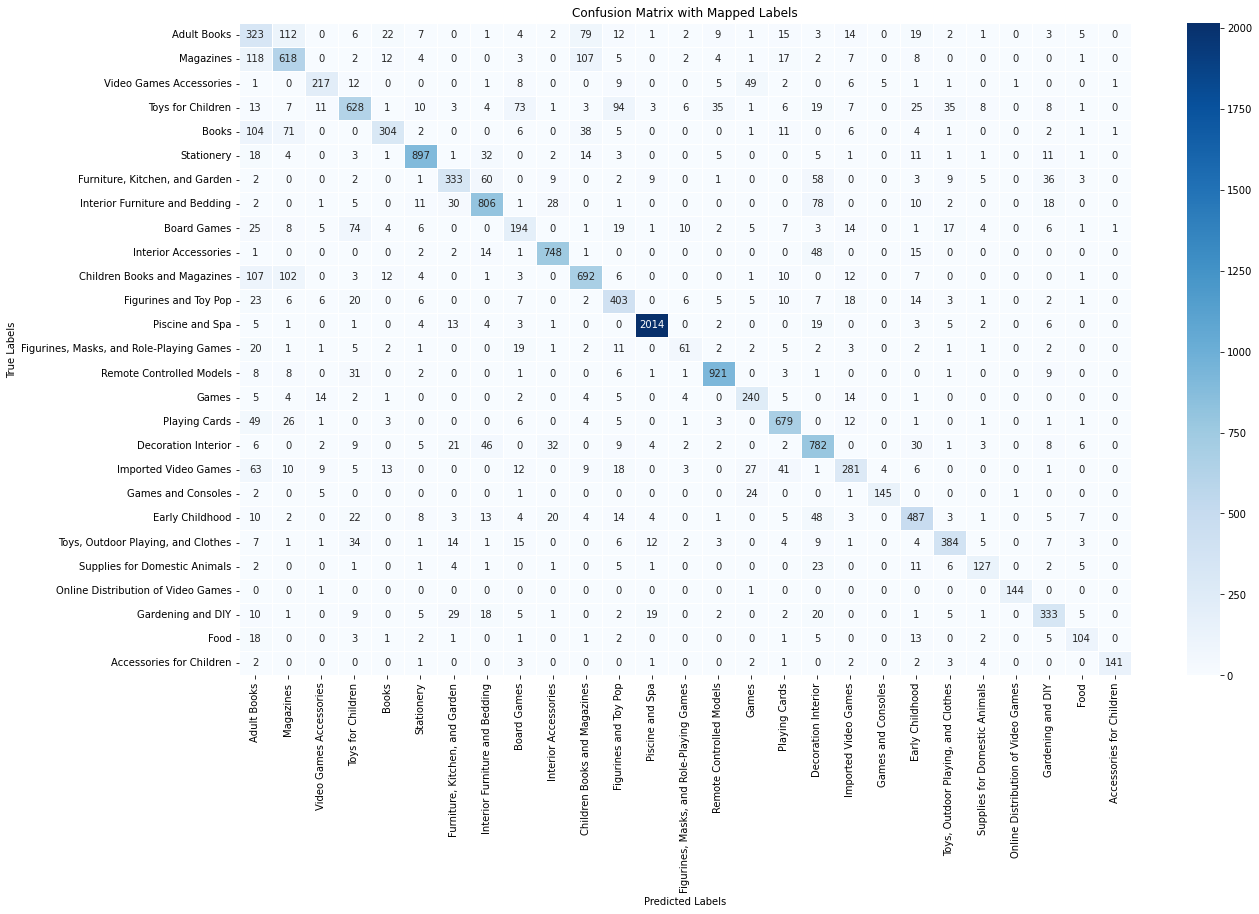

In [23]:
import importlib
importlib.reload(config)  # Reload config to ensure any updates are applied
import src.model_evaluation  # Initial import

importlib.reload(src.model_evaluation)  # Force reload the module
from src.model_evaluation import generate_confusion_matrix  

# Generate the confusion matrix with mapped labels
conf_matrix_df_labeled = generate_confusion_matrix(y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(conf_matrix_df_labeled, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix with Mapped Labels")
plt.show()


### 6.3.2 Breakdown of Misclassifications  
→ **Analyze misclassification trends, identify the most frequently misclassified classes, and assess overall model performance.**  

In this section, we analyze the model’s misclassification patterns using a structured approach.  
We present four breakdowns to understand where the model struggles the most.  

#### **Columns in the Misclassification Table:**  
- **Encoded target** → The encoded numerical representation of each class.  
- **Original prdtypecode** → The original product category code.  
- **Class Label** → The human-readable label of the class.  
- **Samples** → The total number of instances for each class.  
- **Misclassified Count** → The number of misclassified samples for the class.  
- **Misclassification Rate (%)** → The percentage of misclassified samples within the class.  
- **Global Misclassification Rate (%)** → The percentage of misclassified samples relative to the total dataset.  

####  **Key Misclassification Perspectives**  

1. **Classes with the highest number of samples**  
   - Shows the most **frequent classes** in the dataset.  
   - Helps assess whether a class’s misclassification is due to **its high occurrence** or **its inherent difficulty**.  
   - Large classes can dominate misclassification counts even if their misclassification rate is low.  

2. **Classes with the highest number of misclassifications**  
   - Highlights the classes with the **largest absolute number of errors**.  
   - Useful for identifying which classes **contribute the most errors**, regardless of their misclassification rate.  
   - A class with many misclassifications may indicate **model weakness** or **data imbalance**.  

3. **Classes with the highest misclassification rate (%)**  
   - Identifies the classes where the model **struggles the most** proportionally.  
   - A high rate suggests **systematic confusion** in distinguishing this class from others.  
   - Small classes with a **high error rate** might require **better feature representation** or **more training data**.  

4. **Classes contributing the most to overall misclassification (%)**  
   - Measures **each class’s impact on total model errors**.  
   - A class with **many samples and a moderate error rate** can still contribute significantly to overall misclassification.  
   - Helps prioritize which classes should be improved to **reduce total model error** the most.  


By examining these four aspects, we gain insights into both **systematic classification errors** and **dataset imbalances** that could be influencing the model’s performance.  


In [71]:
import importlib

importlib.reload(config)
import src.model_evaluation  # Initial import
importlib.reload(src.model_evaluation)
from src.model_evaluation import analyze_and_display_misclassification

# Calculs déjà réalisés
misclassified_counts = conf_matrix_df_labeled.sum(axis=1) - np.diag(conf_matrix_df_labeled)
total_samples_per_class = conf_matrix_df_labeled.sum(axis=1)
misclassification_rates = round((misclassified_counts / total_samples_per_class) * 100, 2)

# [✔]Call the function with a custom number of rows to display
# You can set `display_rows` to control how many rows are shown in the notebook.
# By default, it displays 10 rows.
misclassification_analysis_df = analyze_and_display_misclassification(
    y_test, y_pred_classes, misclassified_counts, total_samples_per_class, misclassification_rates, display_rows=10
)


[✔] Misclassification analysis DataFrame created!

Top classes with the highest number of samples: (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
12,12,2583,Piscine and Spa,2083,69,3.31,0.41
5,5,2522,Stationery,1011,114,11.28,0.67
3,3,1280,Toys for Children,1002,374,37.33,2.20
7,7,1560,Interior Furniture and Bedding,993,187,18.83,1.10
14,14,1300,Remote Controlled Models,993,72,7.25,0.42
17,17,2060,Decoration Interior,970,188,19.38,1.11
10,10,2403,Children Books and Magazines,961,269,27.99,1.58
1,1,2280,Magazines,911,293,32.16,1.73
9,9,1920,Interior Accessories,832,84,10.10,0.49
16,16,1160,Playing Cards,793,114,14.38,0.67



Top classes with the highest number of misclassifications: (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
3,3,1280,Toys for Children,1002,374,37.33,2.20
0,0,10,Adult Books,643,320,49.77,1.88
1,1,2280,Magazines,911,293,32.16,1.73
10,10,2403,Children Books and Magazines,961,269,27.99,1.58
4,4,2705,Books,557,253,45.42,1.49
18,18,40,Imported Video Games,503,222,44.14,1.31
8,8,1281,Board Games,408,214,52.45,1.26
6,6,2582,"Furniture, Kitchen, and Garden",533,200,37.52,1.18
17,17,2060,Decoration Interior,970,188,19.38,1.11
7,7,1560,Interior Furniture and Bedding,993,187,18.83,1.10



Top classes with the highest misclassification rate (%): (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
13,13,1180,"Figurines, Masks, and Role-Playing Games",144,83,57.64,0.49
8,8,1281,Board Games,408,214,52.45,1.26
0,0,10,Adult Books,643,320,49.77,1.88
4,4,2705,Books,557,253,45.42,1.49
18,18,40,Imported Video Games,503,222,44.14,1.31
6,6,2582,"Furniture, Kitchen, and Garden",533,200,37.52,1.18
3,3,1280,Toys for Children,1002,374,37.33,2.20
25,25,1940,Food,159,55,34.59,0.32
22,22,2220,Supplies for Domestic Animals,190,63,33.16,0.37
1,1,2280,Magazines,911,293,32.16,1.73



Top classes contributing the most to overall misclassification (%): (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
3,3,1280,Toys for Children,1002,374,37.33,2.20
0,0,10,Adult Books,643,320,49.77,1.88
1,1,2280,Magazines,911,293,32.16,1.73
10,10,2403,Children Books and Magazines,961,269,27.99,1.58
4,4,2705,Books,557,253,45.42,1.49
18,18,40,Imported Video Games,503,222,44.14,1.31
8,8,1281,Board Games,408,214,52.45,1.26
6,6,2582,"Furniture, Kitchen, and Garden",533,200,37.52,1.18
17,17,2060,Decoration Interior,970,188,19.38,1.11
7,7,1560,Interior Furniture and Bedding,993,187,18.83,1.10


### 6.3.3 Detailed Misclassification Statistics  
→ **Analyze individual misclassification cases, including total errors, misclassification rates, and overprediction trends.**  

####  Meaning of Columns in the Classification Error Analysis Table  

| **Column**                | **Description** |
|---------------------------|----------------|
| **True Label**            | The actual class of the sample in the test set (the correct category). |
| **Predicted Label**       | The incorrect class predicted by the model instead of the **True Label**. |
| **Count**                 | The number of times samples from **True Label** were misclassified as **Predicted Label**. |
| **Percentage**            | The proportion of this specific misclassification relative to **all misclassified instances**. Computed as: `(Count / Total Misclassified) * 100`. |
| **Class Sample Size** | The total number of test samples belonging to the **True Label** class (i.e., how many instances of this class exist in the test set). |
| **Misclassified Count**   | The total number of **True Label** samples that were misclassified (sum of all errors for this class). |
| **Misclassification Rate** | The error rate for the **True Label** class. Computed as: `(Misclassified Count /Class Sample Size) * 100`. |
| **Total Predicted**       | The total number of test samples predicted as belonging to the **Predicted Label** class (both correctly and incorrectly). |
| **Incorrect Predictions** | The number of test samples **incorrectly predicted** as **Predicted Label** (should have been a different class). |
| **Overprediction Rate**   | The proportion of incorrect predictions for the **Predicted Label** class. Computed as: `(Incorrect Predictions / Total Predicted) * 100`. |



In [58]:
importlib.reload(config) 
import src.model_evaluation  # Initial import
importlib.reload(src.model_evaluation)  # Force reload to use updated functions
from src.model_evaluation import generate_display_misclass_report

# Generate the enriched misclassification report
# NOTE: To display only a subset of rows, modify display_rows when calling the function
# Example: Use display_rows=20 to show only the top 20 rows:
misclassification_report = generate_display_misclass_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH, display_rows=20 # Set top_n to an integer (e.g., 20) to limit rows
)

# # Display the final enriched report
# print("\n[✔] Consolidated Misclassification Report:")
# display(misclassification_report)


Misclassification Report: (showing all rows)



,True Label,Predicted Label,Count,Percentage,Class Sample Size,Misclassified Count,Misclassification Rate,Total Predicted,Incorrect Predictions,Overprediction Rate
0,Magazines,Adult Books,118,2.97%,911,293,32.16%,944,621,65.78%
1,Adult Books,Magazines,112,2.82%,643,320,49.77%,982,364,37.07%
2,Children Books and Magazines,Adult Books,107,2.69%,961,269,27.99%,944,621,65.78%
3,Magazines,Children Books and Magazines,107,2.69%,911,293,32.16%,961,269,27.99%
4,Books,Adult Books,104,2.61%,557,253,45.42%,944,621,65.78%
...,...,...,...,...,...,...,...,...,...,...
387,Playing Cards,Video Games Accessories,1,0.03%,793,114,14.38%,274,57,20.80%
388,Books,Games,1,0.03%,557,253,45.42%,360,120,33.33%
389,Early Childhood,Remote Controlled Models,1,0.03%,664,177,26.66%,1002,81,8.08%
390,Books,"Toys, Outdoor Playing, and Clothes",1,0.03%,557,253,45.42%,480,96,20.00%



[✔] Final Consolidated Report Generated!


### 6.4 **Exporting Classification Analysis to Excel** 

This step saves all classification insights into a **single Excel file** with multiple sheets for easy review.  

####  Exported Data Includes:
- **Well-Classified, Moderately Classified, Poorly Classified** categories (sorted by F1-score).  
- **Misclassification Analysis** (error rates, misclassified counts).  
- **Consolidated Misclassification Report** (detailed misclassification breakdown per class).  
- **Raw Confusion Matrix** (numerical values without labels).  

####  Output File Example:  
**`classification_analysis_<MODEL_NAME>_<TIMESTAMP>.xlsx`**  



In [59]:

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)
print(type(classification_df))
print(type(summary_rows))
print(type(accuracy_value))
print(type(accuracy_support))
    
# Display processed classification report
print("\n[✔] Processed Classification Report with Mapped Classes and Original Labels")
display(classification_df.tail(5))

# Display accuracy separately
print(f"\n[✔] Accuracy: {accuracy_value:.2f} (on {accuracy_support} samples)\n")

# Display final classification summary
print("\n[✔] Classification Summary Rows")
display(summary_rows.tail(5))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.float64'>
<class 'int'>

[✔] Processed Classification Report with Mapped Classes and Original Labels


,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support
22,22,2220,Supplies for Domestic Animals,0.76,0.67,0.71,190
23,23,2905,Online Distribution of Video Games,0.99,0.99,0.99,146
24,24,2585,Gardening and DIY,0.72,0.71,0.71,468
25,25,1940,Food,0.71,0.65,0.68,159
26,26,1301,Accessories for Children,0.98,0.87,0.92,162



[✔] Accuracy: 0.77 (on 16984 samples)


[✔] Classification Summary Rows


,Metric Type,precision,recall,f1-score,support
28,macro avg,0.76,0.73,0.74,16984
29,weighted avg,0.78,0.77,0.77,16984


In [75]:
import importlib
import src.model_evaluation  # Initial import
import src.export_utils  # # Initial import

importlib.reload(config) # Force reload module
importlib.reload(src.model_evaluation)  # Force reload module
importlib.reload(src.export_utils)  # Force reload module

from src.model_evaluation import analyze_and_display_misclassification, generate_display_misclass_report
from src.export_utils import export_all_analysis




# Define model name and file prefix
model_used = "GRU_Model"
file_prefix = "classification_analysis"

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)


# Convert conf_matrix_df_raw to Pandas DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix_df_raw, 
                              index=[f"True Class {label}" for label in set(y_test)],  # Index as True Labels
                              columns=[f"Pred Class {label}" for label in set(y_pred_classes)])  # Columns as Predicted Labels



# Generates and displays misclassification analysis
full_misclassification_analysis_df = analyze_and_display_misclassification(y_test,
                                                                           y_pred_classes,
                                                                           misclassified_counts,
                                                                           total_samples_per_class,
                                                                           misclassification_rates,
                                                                           display_rows=None,
                                                                           display_output=False
)

#Generates and displays a comprehensive misclassification report combining multiple analyses
full_misclassification_report = generate_display_misclass_report(y_test,
                                                                 y_pred_classes,
                                                                 config.PRDTYPECODE_MAPPING_PATH,
                                                                 display_rows=None,
                                                                display_output=False
)



dataframes_to_export = {
    "Class Categorization": {
        f"Well-Classified (F1 ≥ {WELL_CLASSIFIED_THRESHOLD:.2f})": well_classified.sort_values(by="f1-score", ascending=False),
        f"Moderately Classified ({MODERATELY_CLASSIFIED_THRESHOLD:.2f} ≤ F1 < {WELL_CLASSIFIED_THRESHOLD:.2f})": moderately_classified.sort_values(by="f1-score", ascending=False),
        f"Poorly Classified (F1 < {MODERATELY_CLASSIFIED_THRESHOLD:.2f})": poorly_classified.sort_values(by="f1-score", ascending=True),
    },
    "Misclassification Analysis": full_misclassification_analysis_df,
    "Consolidated Misclassification Report": full_misclassification_report,
    "Raw Confusion Matrix": conf_matrix_df
}

# Export all the data
export_path = export_all_analysis(
    dataframes_dict=dataframes_to_export,
    model_name=model_used,
    file_prefix=file_prefix,
    mode="text",
    classification_df=classification_df,
    summary_rows=summary_rows,
    accuracy_value=accuracy_value,
    accuracy_support=accuracy_support
)

# Print confirmation
print(f"\n[✔] Full classification analysis saved to: {export_path}")

[✔] Misclassification analysis DataFrame created!

[✔] Final Consolidated Report Generated!

[✔] Full classification analysis saved to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\reports\classification_reports\text\classification_analysis_GRU_Model_2025-02-25_12-26-59.xlsx


## 7. Hyperparameter Tuning (Optional – Depending on Time & Resources) 

### 7.1 Hyperparameter Search for GRU Cell Model using RandomizedSearchCV  

In this section, we perform **hyperparameter tuning** for the GRU-based text classification model using **RandomizedSearchCV**. Given computational constraints, we focus on optimizing only the **dropout rate** and **number of epochs**, while keeping other parameters fixed. This approach ensures an efficient search while maintaining model performance.  

#### **Fixed Hyperparameters:**  
- **Batch Size = 200**: Initial results showed stable performance with `batch_size=200`, making it a reliable choice.  

#### **Limited Hyperparameter Search:**  
- **Dropout Rate (0.2, 0.3)**: Helps control overfitting and improve generalization.  
- **Epochs (5, 8)**: Ensures training is not too short (underfitting) or too long (wasting resources).  

#### **Efficient Computation:**  
- **n_jobs=1**: Prevents system overload and excessive parallelization.  
- **cv=2**: Balances validation stability and computational cost.  
- **n_iter=4**: Covers all possible combinations of `dropout_rate` and `epochs`.  
- **Early Stopping**: Automatically stops training if validation accuracy doesn’t improve, optimizing resource usage.  


In [ ]:
%%time

# Function to create the model
def create_model(dropout_rate=0.2, epochs=5):
    model = Sequential()
    model.add(Embedding(10000, 200))  # Embedding layer
    model.add(RNN(GRUCell(128), return_sequences=True))  # GRU Layer (Fixed at 128 units)
    model.add(Dropout(dropout_rate))  # Dropout layer
    model.add(GlobalAveragePooling1D())  # Global Average Pooling
    model.add(Dense(256, activation='relu'))  # Dense Layer
    model.add(Dropout(dropout_rate))  # Dropout layer
    model.add(Dense(27, activation='softmax'))  # Output Layer

    # Use Adam optimizer with fixed learning rate
    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


### 7.2 Retraining the GRUCell Model with Optimized Hyperparameters

In [ ]:
# %%time

# from scikeras.wrappers import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from tensorflow.keras.callbacks import EarlyStopping

# # Fixed batch size
# BATCH_SIZE = 200

# # Wrap the Keras model with Sci-Keras KerasClassifier
# model = KerasClassifier(model=create_model, verbose=0)

# # Define early stopping (stop training if val_accuracy doesn’t improve for 3 epochs)
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# # Hyperparameter grid to search (only dropout rate and epochs)
# param_dist = {
#     'model__dropout_rate': [0.2, 0.3],  # Pass as model__dropout_rate for KerasClassifier
#     'model__epochs': [5, 8],  # Pass as model__epochs
# }

# # Use RandomizedSearchCV for hyperparameter tuning
# random_search = RandomizedSearchCV(
#     estimator=model, 
#     param_distributions=param_dist, 
#     n_iter=4,  # Cover all possible combinations
#     cv=2,  # Reduce cross-validation folds for efficiency
#     verbose=2, 
#     n_jobs=-1  
# )

# # Fit the RandomizedSearchCV on the training data
# random_search.fit(X_train, y_train.values)

# # Print the best hyperparameters found
# print(f"Best Hyperparameters: {random_search.best_params_}")


 ### 7.3 Evaluating the Performance of the Best Model

In [ ]:
# # ==========================================================================================
# # Evaluate the Best Model Performance
# # ==========================================================================================

# # Make predictions on the test set
# y_pred_best = best_model.predict(X_test)
# y_pred_best = y_pred_best.argmax(axis=1)  # Convert one-hot or probability outputs to class labels if necessary

# # Compute evaluation metrics
# accuracy = accuracy_score(y_test, y_pred_best)
# weighted_f1 = f1_score(y_test, y_pred_best, average="weighted")

# # Print classification report
# print(f"[✔] Accuracy: {accuracy:.4f}")
# print(f"[✔] Weighted F1-Score: {weighted_f1:.4f}\n")
# print("Classification Report:\n", classification_report(y_test, y_pred_best))

# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_best)

# # Plot the confusion matrix
# plt.figure(figsize=(18, 12))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(27), yticklabels=range(27))
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for the Best GRU Cell Model")
# plt.show()


## 8. Conclusion